In [5]:
import sys
from pathlib import Path

# Define project root (two levels up from this notebook file)
cwd = Path.cwd()
PROJECT_ROOT = cwd.parent

# Insert the project root at the front of sys.path
sys.path.insert(0, str(PROJECT_ROOT))

import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
import utils as ut
sns.set(style="white", font_scale=0.85)

# Path to the sector price parquet
SECTOR_PARQUET = PROJECT_ROOT / "data" / "raw_yfinance" / "sector" / "sector_prices.parquet"

# Check that the file exists
print ("Parquet exists:", SECTOR_PARQUET.exists())

Parquet exists: True


In [11]:
# 1) Read the Parquet file into a DataFrame
_all_fields = pd.read_parquet(SECTOR_PARQUET)
prices = _all_fields.xs("Close", axis=1, level=0)

# 2) Display the last 5 rows to confirm it loaded
print("Resulting columns (should be 11 tickers):", prices.columns.tolist())
prices.head()

Resulting columns (should be 11 tickers): ['XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']


Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,
2014-01-02,36.577644,NaN,56.661152,14.284986,41.894516,30.624670,31.548721,NaN,25.855597,45.982094,58.411667
2014-01-03,36.489895,NaN,56.453304,14.383545,42.008324,30.477560,31.489269,NaN,25.772621,46.090496,58.253597
2014-01-06,36.290447,NaN,56.531254,14.396688,41.764427,30.425648,31.370365,NaN,25.814108,45.898663,57.893585
2014-01-07,36.226635,NaN,56.959866,14.403262,42.024593,30.702545,31.541298,NaN,26.042305,46.382431,58.244846
2014-01-08,36.442032,NaN,56.563709,14.449256,41.951412,30.702545,31.303484,NaN,25.904005,46.791119,58.086788


In [15]:
# 1) Compute simple daily returns for each sector
rets = prices.pct_change().dropna(how="all")

# 2) Display the first 5 rows of returns to confirm
rets.tail()


Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,
2025-05-28,-0.013647,-0.000196,-0.012696,-0.006676,-0.004954,-0.004134,-0.006801,0.000000,-0.013959,-0.005145,-0.009176
2025-05-29,0.003720,-0.008055,0.007471,0.005139,0.000912,0.001687,0.004035,0.009199,0.006954,0.006693,0.000419
2025-05-30,0.000116,0.004159,-0.008874,0.002163,0.000631,-0.003108,0.008769,0.000959,0.010236,0.002115,-0.005443
2025-06-02,0.005907,0.004931,0.013124,0.000392,-0.001260,0.008835,0.000604,0.001438,0.003174,0.000603,0.002339
2025-06-03,0.010248,-0.002846,0.011864,0.001962,0.007712,0.015025,-0.000965,-0.003589,0.002677,0.002336,0.005320


In [14]:
# 1) Call our helper to get a DataFrame of rolling Sharpe values
#    - rf=0.0 means we assume a zero risk-free rate.
#    - window=252 for a one-year lookback.
roll_sharpes = ut.rolling_sharpe(prices, rf=0.0, window=252)

# 2) Drop any rows where all sectors are NaN (e.g., the first 251 days)
roll_sharpes = roll_sharpes.dropna(how="all")

# 3) Show the last few rows (latest dates) of rolling Sharpe for each sector
roll_sharpes.tail()


Ticker,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,
2025-05-28,-0.067854,1.271159,-0.184301,1.167749,0.876421,0.437085,0.718576,0.835383,1.002577,-0.429877,0.987556
2025-05-29,-0.093379,1.164948,-0.160280,1.163420,0.855821,0.415066,0.729127,0.885166,0.985657,-0.366392,0.950603
2025-05-30,-0.073296,1.177487,-0.236220,1.230524,0.921744,0.390971,0.852766,0.923534,1.048734,-0.277913,0.938741
2025-06-02,0.029594,1.230377,-0.114417,1.273198,0.988832,0.440753,0.912508,0.985005,1.144524,-0.225471,0.973811
2025-06-03,0.040343,1.232594,-0.078662,1.256583,0.993017,0.566070,0.885635,0.887869,1.085091,-0.213859,0.971512


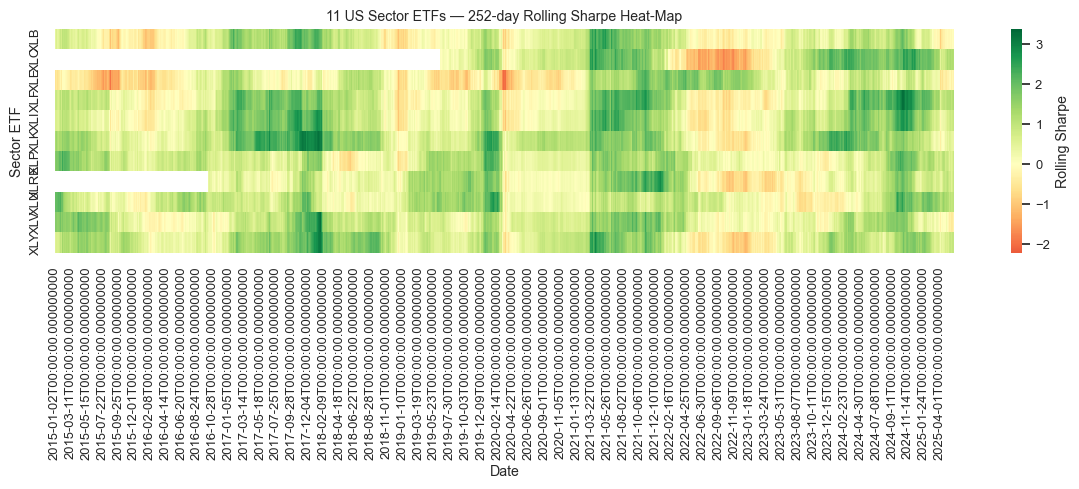

In [16]:
# 1) Create a new figure with a specified size
plt.figure(figsize=(12, 5))

# 2) Call seaborn.heatmap:
#    - data = roll_sharpes.T (transpose so rows=sectors, cols=dates)
#    - cmap="RdYlGn" is a red-yellow-green diverging palette
#    - center=0 ensures that Sharpe=0 is the middle color of the palette
#    - cbar_kws={"label": "Rolling Sharpe"} labels the colorbar
sns.heatmap(
    roll_sharpes.T,
    cmap="RdYlGn",
    center=0,
    cbar_kws={"label": "Rolling Sharpe"}
)

# 3) Add a title and axis labels
plt.title("11 US Sector ETFs — 252-day Rolling Sharpe Heat-Map")
plt.xlabel("Date")
plt.ylabel("Sector ETF")

# 4) Tighten layout so labels don’t get cut off
plt.tight_layout()

# 5) (Optional) Show the plot in Jupyter
plt.show()


In [17]:
# 1) Extract the last row (most recent date) of rolling Sharpe values
latest_sharpe_series = roll_sharpes.iloc[-1]

# 2) Convert to a DataFrame so we can sort and style it
latest_sharpe_df = latest_sharpe_series.to_frame(name="Sharpe_252d")

# 3) Sort by Sharpe descending (so highest Sharpe at the top)
latest_sharpe_df = latest_sharpe_df.sort_values(by="Sharpe_252d", ascending=False)

# 4) Display as a styled table with a color gradient (green = high Sharpe, red = low)
latest_sharpe_df.style.background_gradient(cmap="RdYlGn")


,Sharpe_252d
Ticker,
XLF,1.256583
XLC,1.232594
XLU,1.085091
XLI,0.993017
XLY,0.971512
XLRE,0.887869
XLP,0.885635
XLK,0.566070
XLB,0.040343


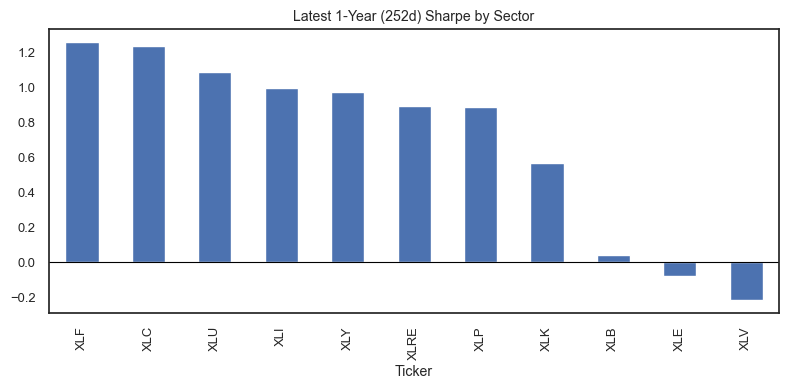

In [18]:
# 1) Create a bar chart with sectors on the x-axis and Sharpe on the y-axis
latest_sharpe_df.plot(
    kind="bar",
    legend=False,
    figsize=(8, 4),
    title="Latest 1-Year (252d) Sharpe by Sector"
)

# 2) Draw a horizontal line at y=0 for reference
plt.axhline(0, color="black", linewidth=0.8)

# 3) Tight layout so labels don’t overlap
plt.tight_layout()

# 4) Show the plot
plt.show()
